In [1]:
#####################################################
# Author: Prof. Marc Jofre
# Dept. Network Engineering
# Universitat Politècnica de Catalunya - Technical University of Catalonia
#
# Modified: 2024
# Created: 2024
#
# Script Quantum LAN application Client layer
#####################################################
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") # Restart the kernel to clean up previous
#####################################################
import sys, os, signal
# print("Python version:", sys.version)
#!pip install --upgrade pip
#!pip install --upgrade pillow
#!pip install matplotlib
#!pip install numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#from google.colab import files
#print(plt.style.available)
mpl.style.use('default')
import time

pathScriptBelowAgentScript='./CppScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptBelowAgentScript='./JupyterPythonScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptData='../../GeneratedDataPythonJupyter/'

def GeneralSettingsPlots():
  SMALL_SIZE = 12
  MEDIUM_SIZE = 16
  BIGGER_SIZE = 18

  plt.rc('figure', figsize=[6.4, 4.8])     # controls default Fgiure size. Default is [6.4, 4.8]
  plt.rc('figure', autolayout = True)      # code will produce the same graphs on differently-configured machines
  plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
  plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
  plt.rc('lines', linewidth=2) # 1 line width
  plt.rc('lines', markersize=10) # 6 marker size
GeneralSettingsPlots()

In [2]:
import QpresentationLayerAgent
#####################################################
# Parameters
## Network
IPhostClientOpNet = "127.0.0.1"#"10.0.0.1" # IP address of the client host (this host) in the operation network
IPhostClientConNet = "192.168.8.1" # IP address of the client host (this host) in the contro/configuration network
IPnodeClientConNet = "192.168.8.2" # IP address of the client node (connected to the client host) in the control/configuration network
IPhostServerOpNet = "127.0.0.2"#10.0.0.3" # IP address of the server host in the operation network
IPnodeServerConNet = "192.168.9.2" # IP address of the server node in the control/configuration network
IPhostDealerOpNet = "127.0.0.3"#10.0.0.4" # IP address of the dealer host in the operation network
IPnodeDealerConNet = "192.168.10.2" # IP address of the dealer node in the control/configuration network

ParamsClientListChar = ["client",IPnodeClientConNet,IPhostClientConNet,IPhostClientOpNet,IPhostServerOpNet,IPhostDealerOpNet]

##############################################################
# Functions
def ListCharArrayParser(ListCharArrayAux):
    # Actually concatenating a python list of strings to a single string
    ParsedCharArrayAux=",".join(ListCharArrayAux)+","
    return ParsedCharArrayAux

# The parameters passed and received from agents are structured
ParamsAscendingCharArray = "none"
ParamsDescendingCharArray = ListCharArrayParser(ParamsClientListChar)

### RUN UP TO HERE (INCLUDED) TO INITIALIZE CONNECTIONS AND THREAD QtransportLayerAgentH thread #####
# At this point, in this order, the node in the server has been initialized, the node in the client, the server host (up to this equivalent point) and then the client host (up to here)
# Create instance of Agent below
QPLAagent = QpresentationLayerAgent.QPLA(ParamsDescendingCharArray,ParamsAscendingCharArray)
def signal_handler(signal_received,frame):
    print(f'Signal {signal_received} received, exiting gracefully.')
    # Perform any cleanup here
    del QPLAagent
    sys.exit(0)

# Set up signal handlers
signal.signal(signal.SIGINT, signal_handler)  # Handle Ctrl+C
signal.signal(signal.SIGPIPE, signal_handler) # Handle broken pipe errors
#signal.signal(signal.SIGSEGV, signal_handler) # Handle segmentation faults (typically memory errors)
signal.signal(signal.SIGHUP, signal_handler) # Handle when terminal window is closed
signal.signal(signal.SIGTERM, signal_handler) # Termination request

### Initiate thread process in QtransportLayerAgentH
QPLAagent.InitAgentProcess() # Initialize the thread in QtransportLayerAgentH

In [ ]:
#####################
# Some tests to send information to the different elements and see them output at the respective console
# The required fields of a message are (separated by commas): IPdestination,IPorigin,Type,Command,Payload
messagePayloadAux="Host client sends information to attached node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostClientOpNet
messageIPdest=IPnodeClientConNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host client sends information to server host"
messageCommandAux="print"
messageTypeAux="Operation"
messageIPorg=IPhostClientOpNet
messageIPdest=IPhostServerOpNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host client sends information to host server node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostClientOpNet
messageIPdest=IPhostServerOpNet # Notice that it is send to the host (which it will forward it to the node)
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

In [ ]:
#### Some test to request QuBits from the other host #################
SynchPRUoffFreqVal=np.asarray([0,0])# Integer value to adjust synch signals offset and frequency for each quantum channel
QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
print('NumStoredQubitsNode[0]: '+str(NumStoredQubitsNode[0]))
print('StatisticsTimeTagDetStoredQubitsNode: '+str(StatisticsTimeTagDetStoredQubitsNode))

In [ ]:
###### Hard resilience test #######
import random
import time
NumTestMax = 100
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
for iIterTest in range(0,NumTestMax,1):
    RandomTestNum=random.randint(0, 1)
    if (RandomTestNum==0):
        # Sending messages
        messagePayloadAux="Host client sends information to attached node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostClientOpNet
        messageIPdest=IPnodeClientConNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host client sends information to server host"
        messageCommandAux="print"
        messageTypeAux="Operation"
        messageIPorg=IPhostClientOpNet
        messageIPdest=IPhostServerOpNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host client sends information to host server node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostClientOpNet
        messageIPdest=IPhostServerOpNet # Notice that it is send to the host (which it will forward it to the node)
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
    else:
        # Sending request
        SynchPRUoffFreqVal=np.asarray([0,0])# Integer value to adjust synch signals offset and frequency for each quantum channel
        QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
        NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
        QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
        ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
        ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
        ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
        ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
        ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
        ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
        ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
        ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
        ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(15.0)
    time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

In [ ]:
# Save generated data
#print(os.getcwd())
ExtraDetailString='PTP'#'NoPTP'#'NoPTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

In [ ]:
# Plot ListNumStoredQubitsNode data
ExtraDetailString='PTP'#'NoPTP'#'NoPTP'
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam0=np.load(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam0,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch1 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam1=np.load(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam1,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch2 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam2=np.load(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam2,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch3 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam3=np.load(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam3,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch4 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam4=np.load(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Multi Ch. hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam5=np.load(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Time diff avg. [count]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam6=np.load(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Time. diff. std [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7)
plt.xlabel('Det. run')
plt.ylabel('Time. abs [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()


In [ ]:
####### Debbuging synch intra runs
# The GPIO c++ unskewing and threshold values are set to zero
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics  in QPhysLayer c++ is modified to this particular case

In [6]:
import time
import random
NumTestMax = 5
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([0,0])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

ListNumStoredQubitsNode: [2048, 2048, 2048, 2048, 2048]
ListStatisticsTimeTaggDetQubitsNodeParam0: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam1: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam2: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam3: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam4: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam5: [3.60136786, 2.82071324, 2.41621886, 2.57059111, 1.17195896]
ListStatisticsTimeTaggDetQubitsNodeParam6: [2.039272, 1.65624188, 1.49798457, 1.60415155, 0.90362956]
ListStatisticsTimeTaggDetQubitsNodeParam7: [3.435547669414826e+17, 3.4355477057597715e+17, 3.4355477361822445e+17, 3.435547764553429e+17, 3.435547796051257e+17]


In [7]:
# Save generated data
#print(os.getcwd())
ExtraDetailString='NTP'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

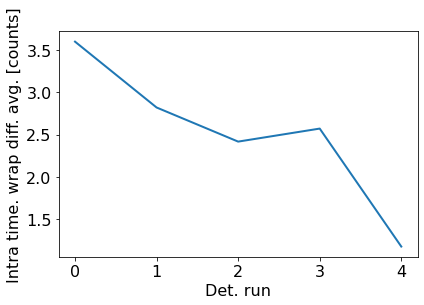

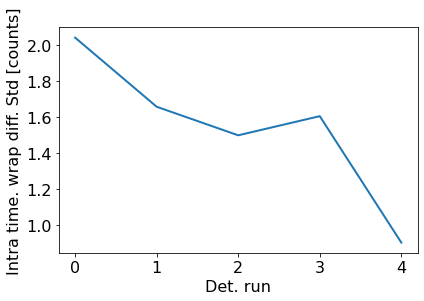

Intra time. wrap diff. avg. [counts]: 2.5161700060000003
Intra time. wrap diff. median [counts]: 2.57059111
Intra time. wrap diff. std [counts]: 1.540255912


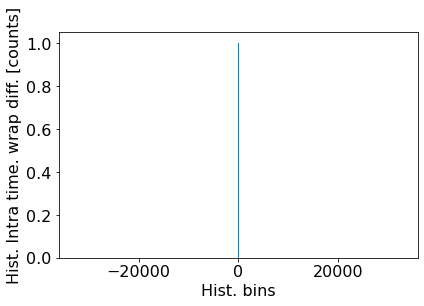

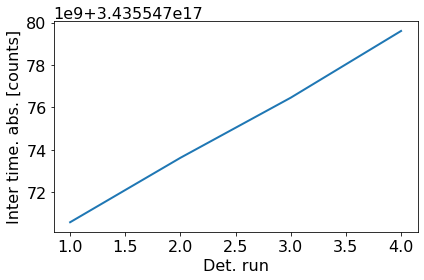

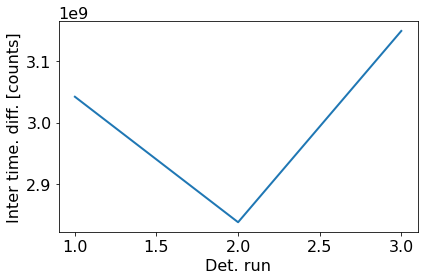

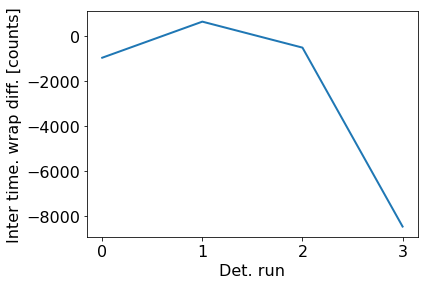

Inter time. wrap diff. avg. [counts]: -2320.0
Inter time. wrap diff. median [counts]: -736.0
Inter time. wrap diff. std [counts]: 3585.821


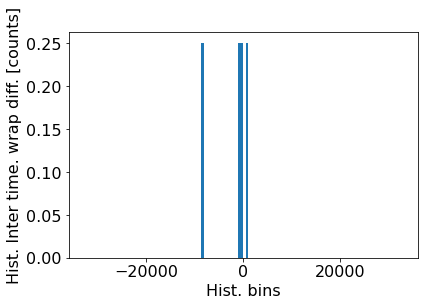

In [8]:
## Synchronization analysis inter and intra runs
# Connect on the timetagg part only channel 1
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[5] stores the mean wrap count difference
# Attention TimeTaggsDetAnalytics[6] stores the std wrap count difference
ExtraDetailString='NTP'#'NoPTP'# 'NTP'#'PTP'
HistPeriodicityAux=8.0*8192.0# Histogram analysis periodicity
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam5=(np.load(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. avg. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam6=(np.load(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. Std [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. median [counts]: '+str(np.median(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. std [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam6)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 32*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(ListStatisticsTimeTaggDetQubitsNodeParam5, bins=bin_edges, density=True)

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Intra time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

#Inter runs checker of the initial detection in channel 1
# The plot below helps adjust the Threshold value (we should a constantly increasing line - never a decrease jump)
# If the first out of place is a up-bump->threshold value too high
# If the first out of place is a down-bump->threshold value too low
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7[1:])
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-2,dtype=np.float32)
for iIter in range(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    IntraRunSynchChecker[iIter-1]=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[iIter]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
# Attention, the np.mod produces inconsistencies for large numbers. Hence, the overall initial offset can be extracted withthe first measurements (as done below) and introduced in the computation of the overall computing for the histogram
OffsetAnalysisLenAux=len(IntraRunSynchChecker)
if (OffsetAnalysisLenAux>100):
  OffsetAnalysisLen=100
else:
  OffsetAnalysisLen=OffsetAnalysisLenAux
IntraRunSynchCheckerOffset=np.zeros(int(OffsetAnalysisLen),dtype=np.float32)
#print('OffsetAnalysisLen: '+str(OffsetAnalysisLen))
for iIter in range(0,int(OffsetAnalysisLen),1):
    IntraRunSynchCheckerOffset[iIter]=(np.mod(HistPeriodicityAux/2.0+ListStatisticsTimeTaggDetQubitsNodeParam7[iIter],HistPeriodicityAux)-HistPeriodicityAux/2.0)
MeanIntraRunSynchCheckerOffset=np.median(IntraRunSynchCheckerOffset)
#print('MeanIntraRunSynchCheckerOffset: '+str(MeanIntraRunSynchCheckerOffset))
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=0*MeanIntraRunSynchCheckerOffset+ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchChecker=IntraRunSynchChecker
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 16*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(HistAuxIntraRunSynchChecker, bins=bin_edges, density=True)

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

In [ ]:
#### Raw analysis of the Timetag binary files
def ParseDataFromTimeTagFile(ArrayBinaryAux):
    # Timetag binary files are formated as lines with 64 bits of time counter and 8 bits of detection channels
    # Furthermore, there are multiples of 2048 detection lines per file
    # So first discover how many lines    
    UINT8perLine=9
    LenUINT8Lines=int(len(ArrayBinaryAux)/UINT8perLine) # Number of lines
    CompleteListCountTags=np.zeros(LenUINT8Lines,dtype=np.uint64)
    CompleteListDet=np.zeros(LenUINT8Lines,dtype=np.uint8)    
    for iIterLines in range(0,LenUINT8Lines,1):
        CurrentCounTag=np.frombuffer(ArrayBinaryAux[iIterLines*UINT8perLine+0:iIterLines*UINT8perLine+8], dtype=np.uint64)[0]
        CurrentDet=np.uint8(ArrayBinaryAux[iIterLines*UINT8perLine+8])
        CompleteListCountTags[iIterLines]=CurrentCounTag
        CompleteListDet[iIterLines]=CurrentDet
    return CompleteListCountTags, CompleteListDet

ExtraDetailString='PTP'#'NTP'#'NoPTP'# 'NTP'#'PTP'
ClientRawStoredQubitsNodeFull=np.fromfile(pathScriptData+'ClientRawStoredQubitsNode'+ExtraDetailString,dtype='uint8')

[ClientRawStoredQubitsNodeCountsTags,ClientRawStoredQubitsNodeDet]=ParseDataFromTimeTagFile(ClientRawStoredQubitsNodeFull)

# Zero Time Point
ClientRawStoredQubitsNodeCountsTags=ClientRawStoredQubitsNodeCountsTags-ClientRawStoredQubitsNodeCountsTags[0]

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ClientRawStoredQubitsNodeCountsTags),1),ClientRawStoredQubitsNodeCountsTags)
plt.xlabel('Time run')
plt.ylabel('Intra time [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

PeriodicityNum=(np.asarray([HistPeriodicityAux])).astype(np.int64)
ListNegativeIncreaseCheckerIndices=[]
IntraRunSynchChecker=np.zeros(len(ClientRawStoredQubitsNodeCountsTags)-1,dtype=float)
for iIter in range(0,len(ClientRawStoredQubitsNodeCountsTags)-1,1):
    DiffCalcAux=(ClientRawStoredQubitsNodeCountsTags[iIter+1]).astype(np.int64)-(ClientRawStoredQubitsNodeCountsTags[1*iIter+0]).astype(np.int64)
    DiffNextCalcAux=(ClientRawStoredQubitsNodeCountsTags[iIter+1]).astype(np.int64)-(ClientRawStoredQubitsNodeCountsTags[1*iIter+0]).astype(np.int64)
    NumCycles=np.round(DiffCalcAux/(PeriodicityNum[0]).astype(float))
    if (DiffNextCalcAux<=0):
        ListNegativeIncreaseCheckerIndices.append(iIter+1)
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+DiffCalcAux,PeriodicityNum[0])-HistPeriodicityAux/2.0)/NumCycles
    #print(NumCycles)
    #print(IntraRunSynchChecker[iIter])
if (len(ListNegativeIncreaseCheckerIndices)>0):
    print('ListNegativeIncreaseCheckerIndices: '+str(ListNegativeIncreaseCheckerIndices))
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ClientRawStoredQubitsNodeCountsTags)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Intra time. wrap diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ClientRawStoredQubitsNodeDet),1),ClientRawStoredQubitsNodeDet)
plt.xlabel('Time run')
plt.ylabel('Detections channels')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

In [ ]:
####### Testing multi-step offset variation synch protocol
# The GPIO c++ unskewing and threshold values are set to zero
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics  in QPhysLayer c++ is modified to this particular case

In [ ]:
import time
NumTestMax = 500
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([0,FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

In [ ]:
# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

In [ ]:
## Synchronization analysis inter and intra runs
# Connect on the timetagg part only channel 1
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[5] stores the mean wrap count difference
# Attention TimeTaggsDetAnalytics[6] stores the std wrap count difference
ExtraDetailString='PTPfreqHist'#'NoPTP'# 'NTP'#'PTP'
HistPeriodicityAux=8.0*8192.0# Histogram analysis periodicity
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam5=(np.load(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. avg. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam6=(np.load(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. Std [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. median [counts]: '+str(np.median(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. std [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam6)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 32*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(ListStatisticsTimeTaggDetQubitsNodeParam5, bins=bin_edges, density=True)

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Intra time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

#Inter runs checker of the initial detection in channel 1
# The plot below helps adjust the Threshold value (we should a constantly increasing line - never a decrease jump)
# If the first out of place is a up-bump->threshold value too high
# If the first out of place is a down-bump->threshold value too low
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7[1:])
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-2,dtype=np.float32)
for iIter in range(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    IntraRunSynchChecker[iIter-1]=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[iIter]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
# Attention, the np.mod produces inconsistencies for large numbers. Hence, the overall initial offset can be extracted withthe first measurements (as done below) and introduced in the computation of the overall computing for the histogram
OffsetAnalysisLenAux=len(IntraRunSynchChecker)
if (OffsetAnalysisLenAux>100):
  OffsetAnalysisLen=100
else:
  OffsetAnalysisLen=OffsetAnalysisLenAux
IntraRunSynchCheckerOffset=np.zeros(int(OffsetAnalysisLen),dtype=np.float32)
#print('OffsetAnalysisLen: '+str(OffsetAnalysisLen))
for iIter in range(0,int(OffsetAnalysisLen),1):
    IntraRunSynchCheckerOffset[iIter]=(np.mod(HistPeriodicityAux/2.0+ListStatisticsTimeTaggDetQubitsNodeParam7[iIter],HistPeriodicityAux)-HistPeriodicityAux/2.0)
MeanIntraRunSynchCheckerOffset=np.median(IntraRunSynchCheckerOffset)
#print('MeanIntraRunSynchCheckerOffset: '+str(MeanIntraRunSynchCheckerOffset))
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=0*MeanIntraRunSynchCheckerOffset+ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchChecker=IntraRunSynchChecker
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 16*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(HistAuxIntraRunSynchChecker, bins=bin_edges, density=True)

num_macro_bins= 3
colors_array=['indigo','blue','darkgreen']

### Generate nice legend
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('figure', figsize=[6.4, 4.8])     # controls default Fgiure size. Default is [6.4, 4.8]
plt.rc('figure', autolayout = True)      # code will produce the same graphs on differently-configured machines
plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=1) # line width
plt.rc('lines', markersize=6) # marker size

lineArray=[]# List
plt.figure(figsize=(6.4, 4.8))
ax = plt.gca()
for iIterMacroBins in range(num_macro_bins):
    lineAux=plt.bar(bin_centers[int((iIterMacroBins)*(len(bin_centers)/num_macro_bins)):int((iIterMacroBins+1)*(len(bin_centers)/num_macro_bins))], hist[int((iIterMacroBins)*(len(hist)/num_macro_bins)):int((iIterMacroBins+1)*(len(hist)/num_macro_bins))]/np.sum(hist[int((iIterMacroBins)*(len(hist)/num_macro_bins)):int((iIterMacroBins+1)*(len(hist)/num_macro_bins))]),width=(bin_edges[1] - bin_edges[0]),color=colors_array[iIterMacroBins])
    lineArray.append(lineAux)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.legend((lineArray[0],lineArray[1],lineArray[2]),('Meas. Freq. 1','Meas. Freq. 2','Meas. Freq. 3'),loc="best",shadow=False,fancybox=False,frameon=False,fontsize='small')
plt.tight_layout()
plt.savefig(pathScriptData+'MeasHistSynchProtAux.eps', bbox_inches='tight', format = 'eps', dpi = 300 )#dpi = 600 )
plt.show()

GeneralSettingsPlots()

In [ ]:
####### Performance multi-step offset variation synch protocol
# The GPIO c++ unskewing and threshold values are set to zero
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics  in QPhysLayer c++ is modified to this particular case

In [ ]:
# Trying to retrieve different situations of offset, and relative frequency offset with respect none of them present
# Situation 1: No offset and no relative frequency offset - calculated in the cells above as ExtraDetailString='PTP'
# Situation 2: A certain offset but no relative frequency offset
# Situation 3: Offset and relative frequency offset present
import time
NumTestMax = 500
# Situation 2: Offset but no relative frequency offset
OffsetSit2=750
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,0])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2Hist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2routineHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)


# Situation 3: Offset and relative frequency offset
OffsetSit3=1500
RelFreqOffsetSit3=250
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3Hist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3+FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3routineHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

In [ ]:
## Analysis of the 3 situations regarding synch offset and relative frequency offset
# Connect on the timetagg part only channel 1
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[5] stores the mean wrap count difference
# Attention TimeTaggsDetAnalytics[6] stores the std wrap count difference

HistPeriodicityAux=8.0*8192.0# Histogram analysis periodicity

###################################################
# Situation 1
ExtraDetailString='PTP'
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit1=IntraRunSynchChecker

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit1)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit1)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit1)))

####################################################
# Situation 2
ExtraDetailString='PTPfreqOffsetSituation2Hist'
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit2=IntraRunSynchChecker

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit2)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit2)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit2)))


ExtraDetailString='PTPfreqOffsetSituation2routineHist'
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit2routine=IntraRunSynchChecker
HistAuxIntraRunSynchCheckerSit2Corrected=HistAuxIntraRunSynchCheckerSit2routine

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit2Corrected)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit2Corrected)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit2Corrected)))

#####################################################
# Situation 3
ExtraDetailString='PTPfreqOffsetSituation3Hist'
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit3=IntraRunSynchChecker

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit3)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit3)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit3)))

ExtraDetailString='PTPfreqOffsetSituation3routineHist'
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit3routine=IntraRunSynchChecker
HistAuxIntraRunSynchCheckerSit3Corrected=HistAuxIntraRunSynchCheckerSit3routine

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit3Corrected)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit3Corrected)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit3Corrected)))

#################################################################################################
# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 16*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist1, bins1 = np.histogram(HistAuxIntraRunSynchCheckerSit1, bins=bin_edges, density=True)
hist2, bins2 = np.histogram(HistAuxIntraRunSynchCheckerSit2, bins=bin_edges, density=True)
hist3, bins3 = np.histogram(HistAuxIntraRunSynchCheckerSit2Corrected, bins=bin_edges, density=True)
hist4, bins4 = np.histogram(HistAuxIntraRunSynchCheckerSit3, bins=bin_edges, density=True)
hist5, bins5 = np.histogram(HistAuxIntraRunSynchCheckerSit3Corrected, bins=bin_edges, density=True)

### Generate nice legend
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('figure', figsize=[6.4, 4.8])     # controls default Fgiure size. Default is [6.4, 4.8]
plt.rc('figure', autolayout = True)      # code will produce the same graphs on differently-configured machines
plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=1) # line width
plt.rc('lines', markersize=6) # marker size

plt.figure(figsize=(6.4, 4.8))
ax = plt.gca()
line1=plt.bar(bin_centers, hist1/np.sum(hist1),width=(bin_edges[1] - bin_edges[0]),color='royalblue')
line2=plt.bar(bin_centers, hist2/np.sum(hist2),width=(bin_edges[1] - bin_edges[0]),color='darkgreen')
line3=plt.bar(bin_centers, hist3/np.sum(hist3),width=(bin_edges[1] - bin_edges[0]),color='forestgreen')
line4=plt.bar(bin_centers, hist4/np.sum(hist4),width=(bin_edges[1] - bin_edges[0]),color='maroon')
line5=plt.bar(bin_centers, hist5/np.sum(hist5),width=(bin_edges[1] - bin_edges[0]),color='firebrick')
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.legend((line1,line2,line3,line4,line5),('Meas. Off.=0 relF=0.0','Meas. Off.=10 relF=0.0','Corr. Off.=10 relF=0.0','Meas. Off.=10 relF=10.0','Corr. Off.=10 relF=10.0'),loc="best",shadow=False,fancybox=False,frameon=False,fontsize='small')
plt.tight_layout()
plt.savefig(pathScriptData+'MeasHistSynchInterChannelAux.eps', bbox_inches='tight', format = 'eps', dpi = 300 )#dpi = 600 )
plt.show()

GeneralSettingsPlots()

In [ ]:
# For the different combination of nodes (respectively)
# Trying to retrieve different situations of offset, and relative frequency offset with respect none of them present
# Situation 1: No offset and no relative frequency offset - calculated in the cells above as ExtraDetailString='PTP'
# Situation 2: A certain offset but no relative frequency offset
# Situation 3: Offset and relative frequency offset present
import time
NumTestMax = 500

## For nodes AB
# Situation 1: No offset and no relative frequency offset
OffsetSit1=0
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit1,0])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation1ABHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Situation 2: Offset but no relative frequency offset
OffsetSit2=750
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,0])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2ABHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2routineABHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)


# Situation 3: Offset and relative frequency offset
OffsetSit3=1500
RelFreqOffsetSit3=250
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3ABHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3+FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3routineABHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

#####################################
# For nodes AC
# Situation 1: No offset and no relative frequency offset
OffsetSit1=0
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit1,0])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostDealerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation1ACHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Situation 2: Offset but no relative frequency offset
OffsetSit2=750
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,0])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostDealerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2ACHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostDealerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2routineACHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)


# Situation 3: Offset and relative frequency offset
OffsetSit3=1500
RelFreqOffsetSit3=250
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostDealerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3ACHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0,500,1500])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3+FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Integer value to adjust synch signals offset and frequency for each quantum channel
    QPLAagent.SimulateRequestQubitsHost(IPhostDealerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128,SynchPRUoffFreqVal) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeClientConNet,IPhostClientConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3routineACHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)